In [118]:
!pip install pandas pyodbc sqlalchemy azure-ai-textanalytics seaborn

In [119]:
# Import necessary libraries
import pyodbc
import pandas as pd
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [120]:
# Step 1: Connect to Azure SQL Database and Retrieve Data
def get_data_from_sql(server, database, username, password, table_name):
    driver = '{ODBC Driver 17 for SQL Server}'
    conn = pyodbc.connect(f'DRIVER={driver};SERVER={server};PORT=1433;DATABASE={database};UID={username};PWD={password}')
    query = f'SELECT * FROM final_yelp_labelled_sentiments'
    data = pd.read_sql(query, conn)
    conn.close()
    return data

In [121]:
def authenticate_client(endpoint, key):
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(endpoint=endpoint, credential=ta_credential)
    return text_analytics_client

In [122]:
def batch_documents(documents, batch_size=10):
    for i in range(0, len(documents), batch_size):
        yield documents[i:i + batch_size]


In [123]:
def sentiment_analysis_example(client, documents):
    sentiments = []
    sentiment_scores = []
    for batch in batch_documents(documents):
        response = client.analyze_sentiment(documents=batch)
        for doc in response:
            if not doc.is_error:
                sentiments.append(doc.sentiment)
                sentiment_scores.append(doc.confidence_scores.positive - doc.confidence_scores.negative)
    return sentiments, sentiment_scores


In [124]:
def visualize_sentiments(data):
    # Ensure we are working with the top 20 records for confusion matrix
    top_20_data = data.head(20)

    # Bar Chart
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x='Sentiment', data=data)
    plt.title('Sentiment Distribution')
    # Donut Chart
    plt.subplot(1, 2, 2)
    sentiment_counts = data['Sentiment'].value_counts()
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title('Sentiment Distribution (Donut Chart)')
    plt.tight_layout()
    plt.show()

    # Sentiment Score Distribution
    plt.subplot(2, 2, 3)
    sns.histplot(data['SentimentScore'], kde=True, bins=30)
    plt.title('Sentiment Score Distribution')

    # Confusion Matrix (Synthetic Example)
    plt.subplot(2, 2, 4)
    # Generate synthetic 'TrueSentiment' for visualization (just for example)
    true_labels = top_20_data['Sentiment'].apply(lambda x: x)  # Use 'Sentiment' as a placeholder
    predicted_labels = top_20_data['Sentiment']

    cm = confusion_matrix(true_labels, predicted_labels, labels=top_20_data['Sentiment'].unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_20_data['Sentiment'].unique())
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Synthetic)')

    plt.tight_layout()
    plt.show()

In [125]:
# Step 6: Save Results to Local Machine
def save_to_local(data, file_name):
    try:
        data.to_csv(file_name, index=False)
        print(f"Data successfully saved to local file {file_name}.")
    except Exception as e:
        print(f"Error saving data to local file: {e}")

In [126]:
def save_to_sql(data, connection_string, table_name):
    try:
        engine = create_engine(connection_string)
        data.to_sql(table_name, con=engine, if_exists='replace', index=False)
        print(f"Data successfully saved to table {table_name} in the database.")
    except Exception as e:
        print(f"Error saving data to SQL: {e}")



In [127]:
def calculate_and_display_metrics(data):
    # Check if 'Sentiment' exists or update with correct column name
    if 'Sentiment' not in data.columns:
        print("Column 'Sentiment' not found. Please check the DataFrame columns.")
        return

    # Generate synthetic 'TrueSentiment' for demonstration
    # In practice, replace this with actual true labels
    top_20_data = data.head(20)
    true_labels = top_20_data['Sentiment'].apply(lambda x: x)  # Use 'Sentiment' as a placeholder
    predicted_labels = top_20_data['Sentiment']

    # Print classification report
    report = classification_report(true_labels, predicted_labels, output_dict=True)
    print("Classification Report:")
    print(report)

    # Optionally, save the report to a file
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv('classification_report.csv')
    print("Classification report saved to 'classification_report.csv'.")

C:\Users\aksha\AppData\Local\Temp\ipykernel_32856\4163518829.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)


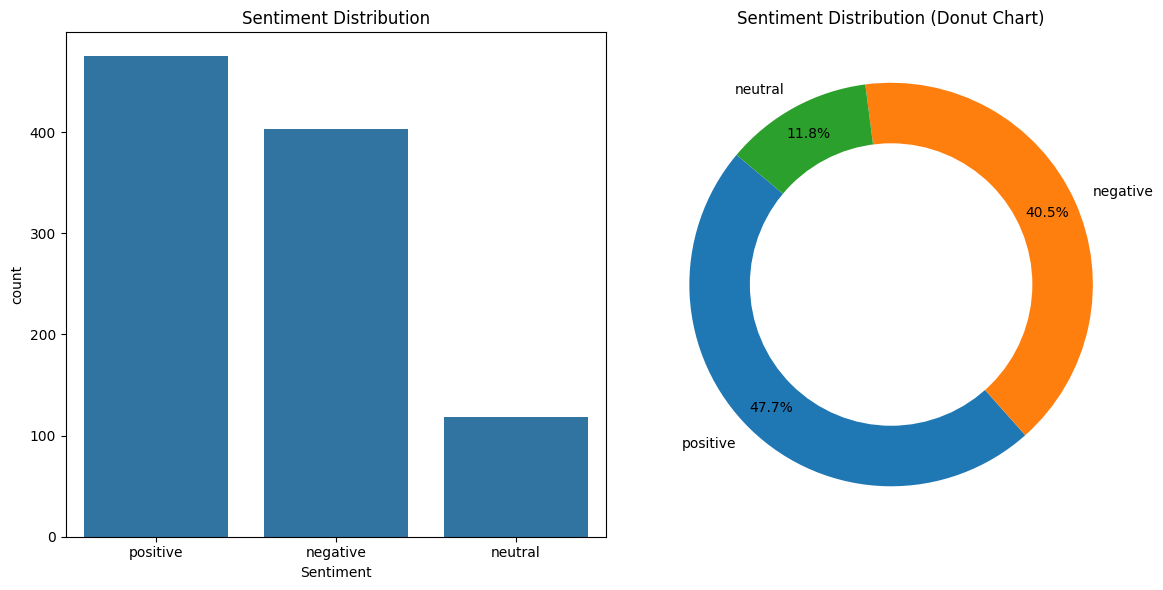

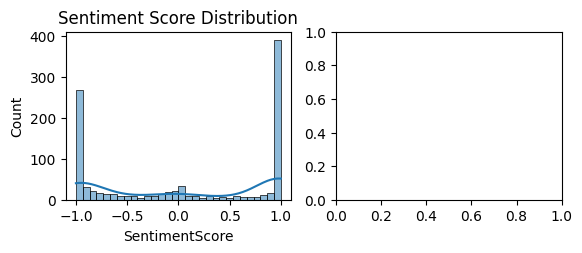

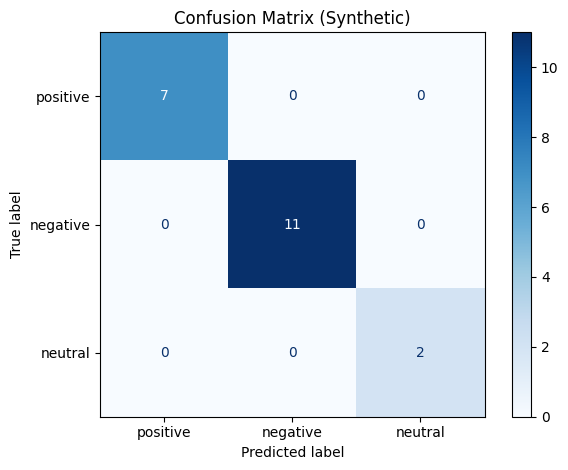

                                          Cleaned_Text category Sentiment  \
0                                 wow loved this place        1  positive   
1                                    crust is not good        0  negative   
2             not tasty and the texture was just nasty        0  negative   
3    stopped by during the late may bank holiday of...        1  positive   
4    the selection on the menu was great and so wer...        1  positive   
..                                                 ...      ...       ...   
991  i think food should have flavor and texture an...        0  negative   
992                            appetite instantly gone        0  negative   
993  overall i was not impressed and would not go back        0  negative   
994  the whole experience was underwhelming and i t...        0  negative   
995  then as if i hadnt wasted enough of my life th...        0  negative   

          Sentiment_Score\r  SentimentScore  
0     0.39999999999999997\r  

In [128]:
def main():
    ## Azure SQL Database details
    server = 'server-akshai.database.windows.net'
    database = 'Infrastructure_AI '
    username = 'admin003'
    password = 'Unnikuttan@2017'
    table_name = 'final_yelp_labelled_sentiments'

    # Azure Cognitive Services details
    endpoint = 'https://assignmentd.cognitiveservices.azure.com/'
    key = '7a0684ec54aa495590d5e1562f98c969'

    # Local file name to save the results
    local_file_name = 'final_yelp_labelled_sentiments.csv'

    # Retrieve data from SQL Database
    data = get_data_from_sql(server, database, username, password, table_name)

    # Authenticate Azure Cognitive Services client
    client = authenticate_client(endpoint, key)

    # Perform sentiment analysis
    documents = data['Cleaned_Text'].tolist()
    sentiments, sentiment_scores = sentiment_analysis_example(client, documents)
    data['Sentiment'] = sentiments
    data['SentimentScore'] = sentiment_scores

    # Visualize the results
    visualize_sentiments(data)

    # Display the DataFrame with Sentiment Analysis Results
    print(data)
    
    # Save the results to local file
    save_to_local(data, local_file_name)

    # Save the results back to SQL Database
    connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
    save_to_sql(data, connection_string, 'CLassified_yelp_labelled_sentiments')

    # Calculate and display accuracy metrics
    calculate_and_display_metrics(data)

# Run the main function
if __name__ == "__main__":
    main()